## IMDB Analysis

In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import torch
import os

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## Task 2e


### DMGI Embeddings

In the case of the IMDB for DMGI, we require data which has a structure of the multiplex network and, in addition, node attributes. For this purpose we are using the IMDB-MULTI dataset, which is used by the authors in the original paper of DMGI. It contains 3 labels and 2 relations, in which two movies are connected with a common director ("MDM") or a common actor ("MAM"). The data can be downloaded from: https://www.dropbox.com/s/ntutrhk8nr3vveb/imdb.pkl?dl=0 and should be located in the "\DMGI\data" directory. 

In [5]:
data_path = "..\DMGI\\data\\imdb.pkl"
embedding_model_path = "./embeddings/"
cwd = os.getcwd()

In [6]:
os.chdir('..\DMGI') 
os.system('python main.py --embedder DMGI --dataset imdb --metapaths MAM,MDM')
os.chdir(cwd) 

In [6]:
# read data info
imdb_data = pickle.load(open(data_path, "rb"))
print(imdb_data.keys())

# merge both to train so we have enough data
tr_idx = np.squeeze(imdb_data['train_idx'])
test_idx = np.squeeze(imdb_data['test_idx'])
train_idx = np.concatenate([tr_idx, test_idx])
print(train_idx.shape)
# validation 
val_idx = np.squeeze(imdb_data['val_idx'])
print(val_idx.shape)

# labels
labels = np.argmax(imdb_data['label'], axis=1)

dict_keys(['label', 'MDM', 'MAM', 'train_idx', 'val_idx', 'test_idx', 'feature'])
(3250,)
(300,)


In [7]:
file_imdb_original = embedding_model_path + "best_imdb_DMGI.pkl"
model_imdb_original = torch.load(file_imdb_original)

In [8]:
X = torch.squeeze(model_imdb_original['H'])

print("Clustering")
kmeans = KMeans(n_clusters=3, random_state=0).fit(X.numpy())
print("NMI:", normalized_mutual_info_score(kmeans.labels_, labels))


X_train, y_train = X[train_idx], labels[train_idx]
X_val, y_val = X[val_idx], labels[val_idx]

print("")
print("Classification task:")
rf = RandomForestClassifier(n_estimators = 150, max_depth=5, random_state = 42)
rf.fit(X_train, y_train)

pred = rf.predict(X_train)
print("Train accuracy:", accuracy_score(pred, y_train))
pred = rf.predict(X_val)
print("Test accuracy:", accuracy_score(pred, y_val))

Clustering
NMI: 0.197263212311989

Classification task:
Train accuracy: 0.7169230769230769
Test accuracy: 0.7033333333333334


The NMI is quite low, indicating that the two cluster obtained from the KMeans algorithm does not match with the true labels. The classification is in general better, as the accuracy score of around 0.7.

## Task 2f



## Additional features

We have added 10 additional features, one for each relation, i.e graph (MAM and MDM). The features include the clustering coefficient of the graph and four centrality measures. We have looked at two scenarios: using these features only and using them together with the initial ones. 

In [9]:
imdb_data = pickle.load(open(data_path, "rb"))
A_MDM = imdb_data['MDM']
A_MAM = imdb_data['MAM']

A_MDM = pd.DataFrame(data=A_MDM)
A_MAM = pd.DataFrame(data=A_MAM)

G_MDM = nx.from_pandas_adjacency(A_MDM)
G_MAM = nx.from_pandas_adjacency(A_MAM)

Gs = [G_MDM, G_MAM]
n = Gs[0].number_of_nodes()

In [10]:
additional_features_all = []
for G in Gs:
    clustering = nx.clustering(G)
    deg_centrality = nx.degree_centrality(G)
    close_centrality = nx.closeness_centrality(G)
    bet_centrality = nx.betweenness_centrality(G, normalized = True, endpoints = False)
    pagerank = nx.pagerank(G, alpha=0.8)
    
    node_properties = [clustering, deg_centrality, close_centrality, bet_centrality, pagerank]
    additional_features = np.zeros((n, 5))

    for i in range(3550):
        for j, feature in enumerate(node_properties):
            additional_features[i][j] = feature[i]
    additional_features_all.append(additional_features)

In [11]:
features = imdb_data['feature']
print("Original:", imdb_data['feature'].shape)

features_all = np.c_[features, additional_features_all[0], additional_features_all[1]]
imdb_data['feature'] = features_all
pickle.dump(imdb_data, open('../DMGI/data/imdb_additional_all.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
print("Original+additional:", imdb_data['feature'].shape)

imdb_data['feature'] = np.c_[additional_features_all[0], additional_features_all[1]]
pickle.dump(imdb_data, open('../DMGI/data/imdb_additional_only.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
print("Additional only:", imdb_data['feature'].shape)

Original: (3550, 2000)
Original+additional: (3550, 2010)
Additional only: (3550, 10)


Note: As only DMGI is compatible for using the node attributes for creating the embeddings, this part is only applicable for the DMGI algorithm.

In [12]:
# run_algorithm
os.chdir('..\DMGI') 
os.system('python main.py --embedder DMGI --dataset imdb_additional_all --metapaths MAM,MDM')
os.system('python main.py --embedder DMGI --dataset imdb_additional_only --metapaths MAM,MDM')
os.chdir(cwd) 

In [13]:
file_imdb_all = embedding_model_path + "best_imdb_additional_all_DMGI.pkl"
model_imdb_all = torch.load(file_imdb_all)

file_imdb_only = embedding_model_path + "best_imdb_additional_only_DMGI.pkl"
model_imdb_only = torch.load(file_imdb_only)

In [14]:
names = ["Additional features only", "All features"]
for i, model in enumerate([model_imdb_only, model_imdb_all]):
    print(names[i])
    X = torch.squeeze(model['H'])

    print("Clustering")
    kmeans = KMeans(n_clusters=3, random_state=0).fit(X.numpy())
    print("NMI:", normalized_mutual_info_score(kmeans.labels_, labels))


    X_train, y_train = X[train_idx], labels[train_idx]
    X_val, y_val = X[val_idx], labels[val_idx]

    print("")
    print("Classification task:")
    rf = RandomForestClassifier(n_estimators = 150, max_depth=5, random_state = 42)
    rf.fit(X_train, y_train)

    pred = rf.predict(X_train)
    print("Train accuracy:", accuracy_score(pred, y_train))
    pred = rf.predict(X_val)
    print("Test accuracy:", accuracy_score(pred, y_val))

    print("============================")

Additional features only
Clustering
NMI: 0.004875271429108782

Classification task:
Train accuracy: 0.5172307692307693
Test accuracy: 0.36666666666666664
All features
Clustering
NMI: 0.1969904722492379

Classification task:
Train accuracy: 0.708
Test accuracy: 0.7033333333333334


Now, instead of adding the additional features for computing the embeddings, we try to add the node properties information to the embedding, i.e to concatinate them together. 

In [15]:
X = torch.squeeze(model_imdb_original['H'])
X1 = np.c_[additional_features_all[0], additional_features_all[1]]
X2 = np.c_[X, additional_features_all[0], additional_features_all[1]]

for i, X in enumerate([X1, X2]):

    print(names[i])
        
    print("Clustering")
    kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
    print("NMI:", normalized_mutual_info_score(kmeans.labels_, labels))

    X_train, y_train = X[train_idx], labels[train_idx]
    X_val, y_val = X[val_idx], labels[val_idx]

    print("")
    print("Classification task:")
    rf = RandomForestClassifier(n_estimators = 150, max_depth=5, random_state = 42)
    rf.fit(X_train, y_train)

    pred = rf.predict(X_train)
    print("Train accuracy:", accuracy_score(pred, y_train))
    pred = rf.predict(X_val)
    print("Test accuracy:", accuracy_score(pred, y_val))
    
    print("============================")

Additional features only
Clustering
NMI: 0.0034405386815072976

Classification task:
Train accuracy: 0.49938461538461537
Test accuracy: 0.41
All features
Clustering
NMI: 0.1966942642406

Classification task:
Train accuracy: 0.7187692307692307
Test accuracy: 0.7166666666666667


It seems that when using the additional information, such as the clustering coeffient and the centrality measures, in all cases, does not improve the model's accuracy in predicting the labels, which suggests that the labels are not connected with the structure of the graph, which mathces our findings in Task 1.

### Structure analysis (clustering coefficient, centrality measures)

To further investigate this, we produce plots in order to see the distribution of these features for each label separately and for both relation graphs.

Clustering coefficient


<Figure size 960x400 with 0 Axes>

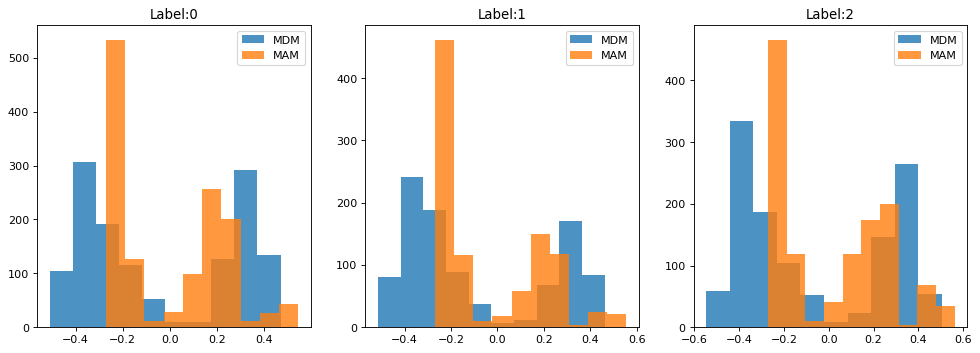

Degree centrality


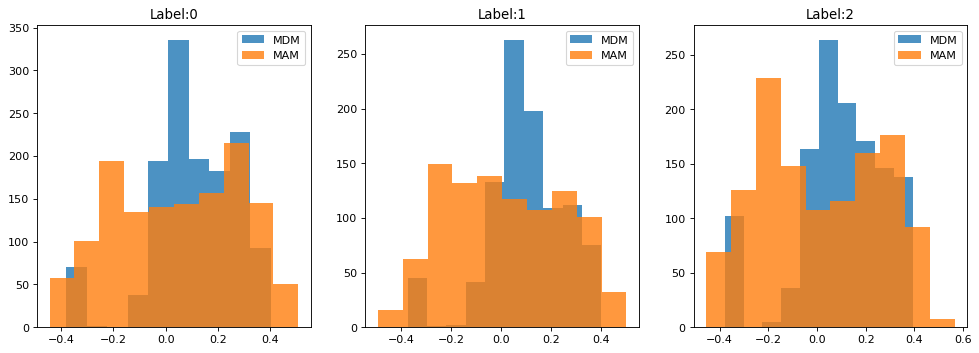

Close centrality


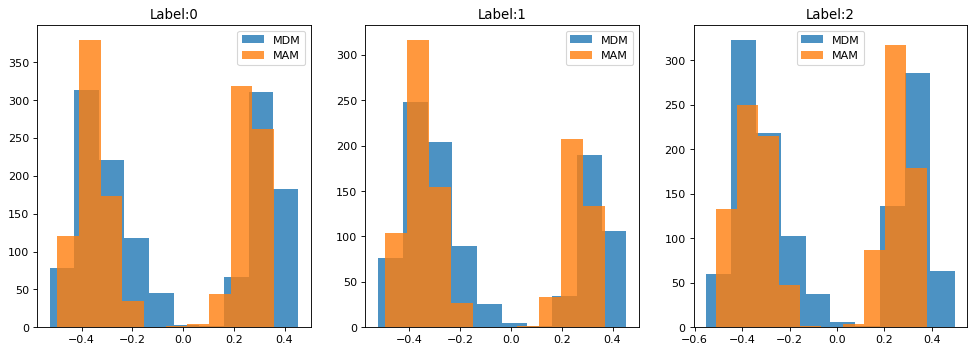

Betweeness centrality


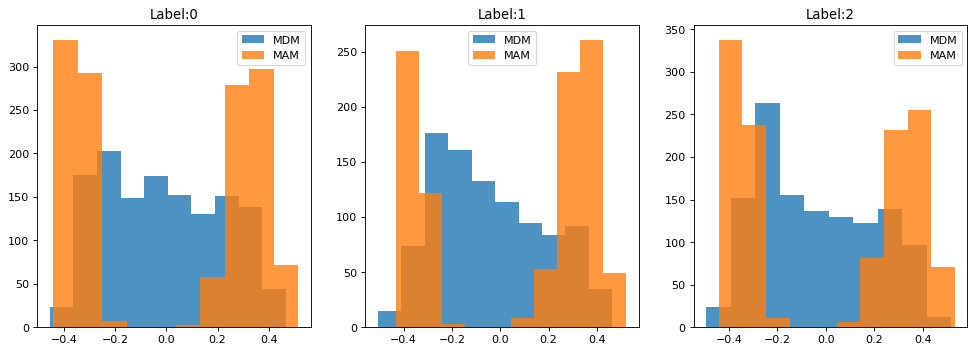

PageRank


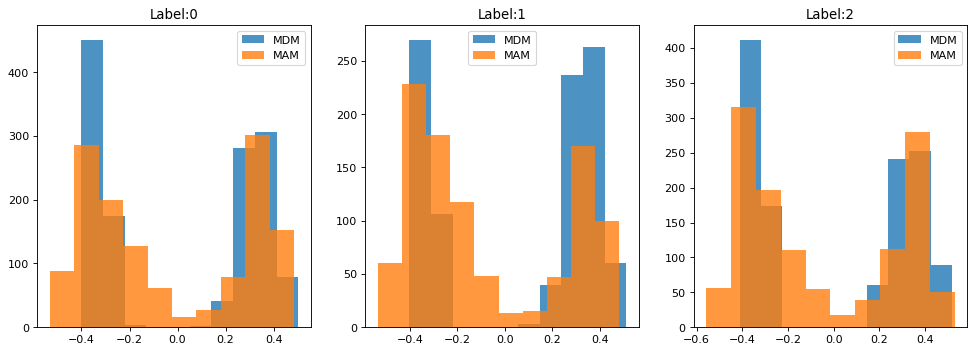

In [29]:
figure(figsize=(12, 5), dpi=80)
data = torch.squeeze(model_imdb_only['H'])
features = ["Clustering coefficient", "Degree centrality", "Close centrality", "Betweeness centrality", "PageRank"]
for i in range(5):
    print(features[i])
    f = figure(figsize=(15, 5), dpi=80)
    for label in [0, 1, 2]:
        plt.subplot(1, 3, label+1)
        indexes = np.where(labels==label)[0].tolist() 
        
        plt.hist(data[indexes, i].numpy(), alpha=0.8, label="MDM")
        plt.hist(data[indexes, i+5].numpy(), alpha=0.8, label="MAM")
        plt.title("Label:" + str(label))
        plt.legend()
    plt.show()

One can observe that the two graphs have quite different node feature values in some of the cases, e.g. clustering coefficient, degree centrality and betweeness centrality. Label-wise in most cases it seems that there aren't apparent differences, apart from the PageRank feature, where the MDM graph has low values for label 1, and high values for label 0 and 2.